In [24]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import QFTGate  
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit.library.basis_change import QFT
from ladder import ladder_up

In [25]:
def neqr(intensity,x,y,image):

    intensity_bits = len(intensity)
    position = list(x) + list(y)
    position_bits = len(position)
    qc = QuantumCircuit(intensity,position, name = "NEQR")

    flat_image = image.flatten()

    for pos in range(position_bits ** 2):
        intensity = int(flat_image[pos])
        bin_intensity = format(intensity, f'0{intensity_bits}b')[::-1]  # 8 qubit binary

        # Control based on position qubits
        control_bits = format(pos, '02b')  # binary position
        controls = []
        for j, cb in enumerate(control_bits):
            qubit = intensity_bits + j
            if cb == '0':
                qc.x(qubit)
            controls.append(qubit)
        
        for i, bit in enumerate(bin_intensity):
            if bit =='1':
                qc.mcx(controls, i) 

        for j, cb in enumerate(control_bits):
                    if cb == '0':
                        qc.x(intensity_bits + j)  # Undo X
    return qc.to_gate()

In [26]:
def neqr_2x2(image):


    intensity_bits = 2
    position_bits = 2  # 2 qubits for 4 positions (2x2)
    total_qubits = intensity_bits + position_bits

    qc = QuantumCircuit(total_qubits)

    # Step 1: Put position qubits into superposition
    qc.h(range(intensity_bits, total_qubits))

    # Step 2: Encode each pixel's intensity value
    flat_image = image.flatten()  # length 4: [I0, I1, I2, I3]

    for pos in range(position_bits ** 2):
        intensity = int(flat_image[pos])
        bin_intensity = format(intensity, '02b')  # 8 qubit binary

        # Control based on position qubits
        control_bits = format(pos, '02b')  # binary position
        controls = []
        for j, cb in enumerate(control_bits):
            qubit = intensity_bits + j
            if cb == '0':
                qc.x(qubit)
            controls.append(qubit)
        
        for i, bit in enumerate(bin_intensity):
            if bit =='1':
                qc.mcx(controls, i) 

        for j, cb in enumerate(control_bits):
                    if cb == '0':
                        qc.x(intensity_bits + j)  # Undo X

    return qc

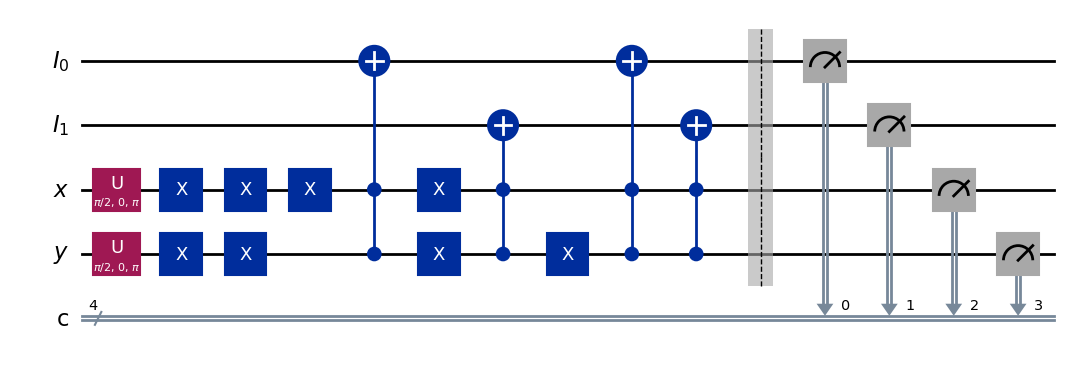

In [27]:
num_bits = 1
x_val = 3
y_val = 7
num_total_qubits = 2 * num_bits + 1
intensity = QuantumRegister(2,name='I')
x = QuantumRegister(num_bits, name='x')
y = QuantumRegister(num_bits, name='y')
cr = ClassicalRegister(4, name = 'c')
qc = QuantumCircuit(intensity,x,y,cr)
image = np.array([
    [0, 1],
    [2, 3]
])
qc.h(x)
qc.h(y)
qc.append(neqr(intensity,x,y,image), list(intensity) + list(x) + list(y))
#qc.append(ladder_up(x),list(x))
qc.barrier()
qc.measure(list(intensity) + list(x) + list(y), list(cr))
qc.decompose().draw('mpl')

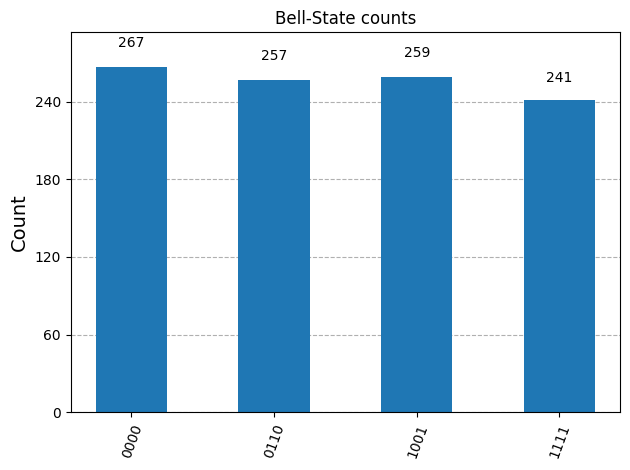

In [28]:
simulator = AerSimulator()
circ = transpile(qc, simulator)

result = simulator.run(circ).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='Bell-State counts')